In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 3. Image Centroid Accuracy

*Author: Jiarong Zhu*

This problem tests the measurement of image centroids.

(a) Write a piece of code to generate a fake, critically-sampled image of a double Gaussian, with a center that isn’t necessarily at the center of a pixel. For the second Gaussian, use A2 = 0.1A1 and σ2 = 2.47σ1, where A indicates the value at the center of the Gaussian. This choice is an approximate description of the atmospheric PSF (Jim Gunn, private communication).

(b) Write a routine to find the light-weighted centroid of the image. Start by using the maximum pixel value, and use your knowledge of the PSF FWHM to calculate the center based on the light within 3 FWHM, and iterate to convergence.

(c) Write a routine to find the mode of the image. Start by using the maximum pixel value, but then use the 3×3 grid of pixels in the center to perform a quadratic interpolation to find the peak.

(d) Now add noise to the images, and use a Monte Carlo test to evaluate how the precision of each estimate depends on the total S/N within 3 FWHM.

### 3.a. Double Gaussian Image

Generate double gaussian image. Note that to be at least critically sampled,
the FWHM of PSF should be at least 2 pixels. Here I set up (x,y) exactly
equal to index (i,j) to make life easier. The real position of the peak
is set up to be not at the center of a pixel.


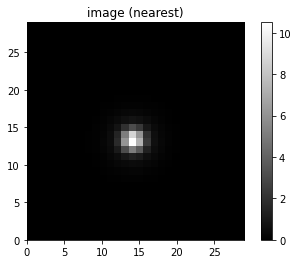

In [1]:
A1, A2 = 10, 1
sig1 = 1.
sig2 = 2.47 * sig1
xc, yc = 13.3, 14.1    #real center
a = 2 * np.sqrt(2 * np.log(2))  # a ~ 2.4
FWHM1, FWHM2 = a * sig1, a * sig2

dx, dy = 1, 1   #dx,dy<=sqrt(2*np.log(2))*sig1~1.2
x = np.arange(0, 30., dx)
y = np.arange(0.,30., dy)
xx, yy = np.meshgrid(x, y)  #xx,yy=i,j
Nx = len(x)
Ny = len(y)

z = (A1 * np.exp(- ((xx - xc)**2 + (yy - yc)**2) / (2 * sig1**2)) +
     A2 * np.exp(- ((xx - xc)**2 + (yy - yc)**2) / (2 * sig2**2)))
z = z.transpose()
#refer to value at (xx,yy): z[i,j]

plt.figure()
plt.imshow(z, cmap='gray', vmin=z.min(), vmax=z.max(),
           extent=[x.min(), x.max(), y.min(), y.max()],
           interpolation='nearest', origin='lower')
plt.title('image (nearest)')
plt.colorbar()
plt.show()

### 3.b. Light-weighted Centroid

The ight-weighted centroid can be calculated through this equation:

$x_{i,0} = \frac{\sum x_i* flux}{\sum flux}$

The FWHM of PSF should be of the same order as the maximum in {FWHM1, FWHM2}, so I use the latter to give 3FWHM range.

In [2]:
def light_weighted_centroid(z, noise):
    data = z + noise
    index = np.where(data == np.amax(data))  # find index of pixel with maximum value
    i0, j0 = index[0].item(), index[1].item()

    R = int(3 * min(FWHM2, FWHM1) /dx)
    
    l0 = 0  # 0th order moment
    l1 = np.array([0, 0])  # 1st order moment

    for i in range(len(x)):
        for j in range(len(y)):
            if ((i - i0)**2 + (j - j0)**2 <= R**2):
                l0 = l0 + data[i, j]
                l1 = l1 + np.array([i, j]) * data[i, j]
            
    (x0, y0) = l1 / l0  #light-weighted centroid
    
    return x0, y0
           
x0,y0 = light_weighted_centroid(z, np.zeros((Nx, Ny)))
print('The light-weighted centroid: (x0, y0) = ', (x0, y0))

The light-weighted centroid: (x0, y0) =  (13.290779598277219, 14.096925815213309)


# 3.c. Fit Quadratic Function

Use values of 3*3 grid of pixels while the center pixel has maximum pixel value, perform quadratic fitting, i.e. fitting to function $f = c_0 + c_1 x+c_2 y +c_3 x^2 + c_4 y^2 $. With all coefficients fitted, we can estimate the centroid to be at $x_0 = - \frac{c_3}{2 c_1}, y_0 = - \frac{c_4}{2 c_2}$. Since the number of data points is 9, which is greater than the number of coefficients needed to fit, we can apply svd to make use of all data.

In [3]:
def quad_fitting_centroid(z, noise):
    data = z + noise
    index = np.where(data == np.amax(data)) # find index of pixel with maximum value
    i0, j0 = index[0].item(),index[1].item()
    X0, X1, X2, X3, X4 = np.ones(9), [], [], [], []
    Y = []

    for i in range(i0 - 1, i0 + 2):
        for j in range(j0 - 1, j0 + 2):
            X1.append(i - i0)
            X2.append(j - j0)
            X3.append((i - i0)**2)
            X4.append((j - j0)**2)
            Y.append(np.log(data[i, j]))
        
    B = np.array([X0, X1, X2, X3, X4])  
    A = B.transpose()
    (u, w, v) = np.linalg.svd(A, full_matrices=False)
    inv_w = 1. / w 
    c = v.transpose().dot(np.diag(inv_w)).dot(u.transpose()).dot(Y)

    x0, y0 = i0 - c[1] / (2 * c[3]), j0 - c[2] / (2. * c[4])

    return x0, y0

x0, y0 = quad_fitting_centroid(z, np.zeros((Nx, Ny)))
print('The centroid estimated by quadratic fitting: (x0, y0)=', (x0, y0))

The centroid estimated by quadratic fitting: (x0, y0)= (13.294925852265052, 14.097477362529526)


### 3.d. Effect of Noise

Add noise to the image and estimate the position of centroid by two estimators above. Use Monte Carlo to calculate Root Mean Square Error (RMSE) of the sample mean of two estimators.

In [10]:
def RMSE_by_MC(estimator, noise_level, signal, xc, yc): #noise=noise_level*np.random.rand(Nx,Ny)
    Nx = Ny = len(signal)
    nk = 1000
    
    mse1 = []
    mse2 = []    
    
    xe = np.zeros(nk)
    ye = np.zeros(nk)
    for k in range(nk):

        noise = noise_level * np.random.randn(Nx, Ny)
        txe, tye = estimator(signal, noise)
        xe[k] = txe
        ye[k] = tye
        
    RMSE1 = np.sqrt(((xe - xc)**2).sum() / np.float32(nk))
    RMSE2 = np.sqrt(((ye - yc)**2).sum() / np.float32(nk))
    
    return RMSE1, RMSE2

R = int(min(FWHM2, FWHM1) / dx) + 1
print(FWHM2)
print(FWHM1)
print(R)
print(dx)

def SNR(z, noise_level, R):
    index = np.where(z == np.amax(z)) # find index of pixel with maximum value
    i0, j0 = index[0].item(),index[1].item()
    
    Nx = Ny = len(z)
    s = 0
    n2 = 0
    
    for i in range(Nx):
        for j in range(Ny):
            if ((i - i0)**2 + (j - j0)**2 <= R**2):
                s = s + z[i, j]
                n2 = n2 + noise_level**2 
                
    n = np.sqrt(n2)
    snr = s / n    
    return snr

noise_level = 1 #an example
snr = SNR(z, noise_level, R)
r1, r2 = RMSE_by_MC(light_weighted_centroid, noise_level, z, xc, yc)
print(r1, r2, snr) 
print(z.sum())


5.81640551123
2.35482004503
3
1
0.43677708119 0.427844192642 15.2502332554
101.164938064


Below I generate a series of noises and calculate RMSEs of xc and yc for both estimators. Then plot RMSEs as a function of S/N within 3FWHM.

In [14]:
noise_level_list = [0.05, 0.1, 0.5, 1., 2.]

snr = []
rx1,ry1 = [], []
rx2,ry2 = [], []

for noise_level in noise_level_list:
    print(noise_level)
    snr.append(SNR(z, noise_level, R))
    rrx1, rry1 = RMSE_by_MC(light_weighted_centroid, noise_level, z, xc, yc)
    rrx2, rry2 = RMSE_by_MC(quad_fitting_centroid, noise_level, z, xc, yc)
    rx1.append(rrx1)
    ry1.append(rry1)
    rx2.append(rrx2)
    ry2.append(rry2)

0.05
0.1
0.5
1.0


<ipython-input-3-759fce33b805>:14: RuntimeWarning: invalid value encountered in log
  Y.append(np.log(data[i, j]))


2.0


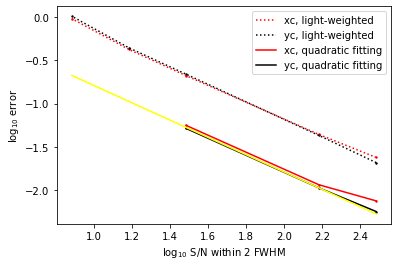

In [16]:
plt.figure()
plt.plot(np.log10(snr), np.log10(rx1), color='red', linestyle='dotted', label='xc, light-weighted')
plt.plot(np.log10(snr), np.log10(ry1), color='black', linestyle='dotted', label='yc, light-weighted')
plt.plot(np.log10(snr), np.log10(rx2), color='red', label='xc, quadratic fitting')
plt.plot(np.log10(snr), np.log10(ry2), color='black', label='yc, quadratic fitting')
plt.scatter(np.log10(snr), np.log10(rx1), color='red', s=2)
plt.scatter(np.log10(snr), np.log10(ry1), color='black', s=2)
plt.scatter(np.log10(snr), np.log10(rx2), color='red', s=2)
plt.scatter(np.log10(snr), np.log10(ry2), color='black', s=2)
plt.plot(np.log10(snr), np.log10(0.685 * FWHM1 / np.array(snr)), color='yellow')
plt.xlabel('$\log_{10}$ S/N within 2 FWHM')
plt.ylabel('$\log_{10}$ error')
plt.legend()
plt.show()

The yellow line indicates $0.685~{\rm FWHM}~/~(S/N)$, which should approximate the Cramer-Rao bound (the "best possible" behavior), as discussed by Vakili & Hogg (2016; https://ui.adsabs.harvard.edu/abs/2016arXiv161005873V/abstract). So the quadratic fit centroid does pretty well.